In [7]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import tensorflow.keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD100T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

/home/dell15/miniconda3/envs/drugnn_conda/lib/python3.8/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')

drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [122]:
DTI_index['activity']

0        intermediate
1            inactive
2        intermediate
3            inactive
4            inactive
             ...     
61619        inactive
61620        inactive
61621        inactive
61622        inactive
61623    intermediate
Name: activity, Length: 61624, dtype: object

In [123]:
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [4]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
#input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
#dense_2_dropout = Dropout(0.4)(dense_2)

x_output = Dense(3, activation='softmax')(dense_2)

# Bulid and compile model
model = Model(inputs=[input_target, input_drug], outputs=x_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model1.summary()

In [5]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, y_train, y_test = train_test_split(pad_target, pad_drug, y, test_size=0.2, random_state=20)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [20]:
# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=40, verbose=1)
filepath='checkpoints/'+EXP+'/'+EXP+'_cp.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(
    [train_target, train_drug], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint]
    )

===========================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7817
Epoch 00225: val_loss did not improve from 0.68084
155/155 [==============================] - 32s 207ms/step - loss: 0.5577 - accuracy: 0.7817 - val_loss: 0.7105 - val_accuracy: 0.7164
Epoch 226/500
155/155 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7831
Epoch 00226: val_loss did not improve from 0.68084
155/155 [==============================] - 32s 207ms/step - loss: 0.5544 - accuracy: 0.7831 - val_loss: 0.7018 - val_accuracy: 0.7254
Epoch 227/500
155/155 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7853
Epoch 00227: val_loss did not improve from 0.68084
155/155 [==============================] - 32s 207ms/step - loss: 0.5523 - accuracy: 0.7853 - val_loss: 0.7174 - val_accuracy: 0.7242
Epoch 228/500
155/155 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7834
Epoch 00228: val_loss did not improve from 0.68084
155/155 [===============

In [14]:
model.save('my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


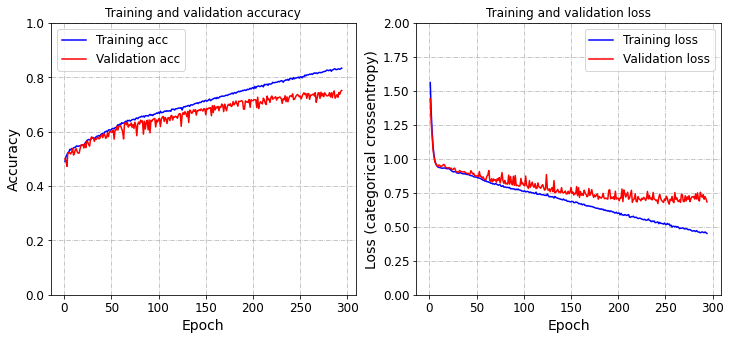

In [26]:
obj.plotTrainingPerf(history, save=True)

In [22]:
# Load saved model
saved_model = tf.keras.models.load_model('checkpoints/'+EXP+'/'+EXP+'_cp.hdf5', custom_objects={'attention': architecture.attention()})

# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug)
precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug)

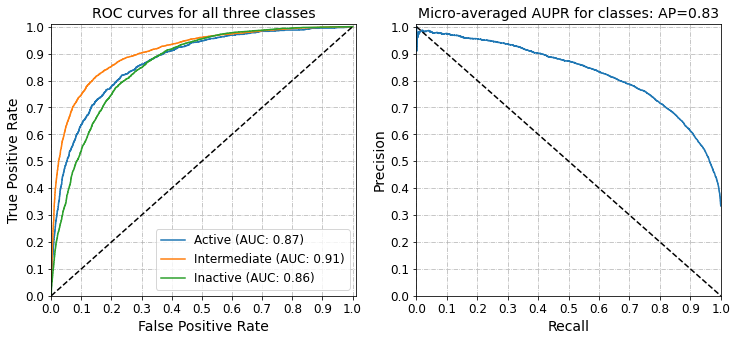

In [25]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=True)

In [24]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([test_target, test_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
49/49 [==============================] - 7s 141ms/step - loss: 0.6546 - accuracy: 0.7523
test loss, test acc: [0.6545579433441162, 0.7522920966148376]


In [160]:
# EXTERNAL VALIDATION
davis_metz_DTI = pd.read_csv('val_data/davis_metz_DTI.csv')
davis_metz_targets = os.listdir('val_data/fasta_davis_metz')  # List all target fasta files
davis_metz_drug_smiles = pd.read_csv('val_data/davis_metz_smiles.csv')

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_metz/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_metz_target_seq = fetchFasta(davis_metz_targets)

100%|██████████| 154/154 [00:00<00:00, 756.52it/s]


In [162]:
eval_P = pd.DataFrame()
for target in davis_metz['protein_id']:
    dic = davis_metz_target_seq[davis_metz_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_metz['compound_id']:
    dic = davis_metz_drug_smiles[davis_metz_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

# label/integer encoding output variable: (y)
davis_metz_le = LabelEncoder()
davis_metz_y = davis_metz_le.fit_transform(davis_metz_DTI['activity'].tolist())
# One hot encoding of outputs
davis_metz_y = to_categorical(davis_metz_y)

In [163]:
davis_metz_codes_drug = [char for char in ''.join(set(''.join(davis_metz_drug_smiles['seq'].values)))]
davis_metz_char_dict_drug = obj.create_dict(davis_metz_codes_drug)

davis_metz_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_metz_encode_drug = obj.integer_encoding(eval_T, davis_metz_char_dict_drug) 

# padding sequences
max_length = 1000
davis_metz_pad_target = pad_sequences(davis_metz_encode_target, maxlen=max_length, padding='post', truncating='post')
davis_metz_pad_drug = pad_sequences(davis_metz_encode_drug, maxlen=max_length, padding='post', truncating='post')

davis_metz_pad_target.shape, davis_metz_pad_drug.shape, davis_metz_y.shape

((2575, 1000), (2575, 1000), (2575, 3))

In [164]:

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_metz_pad_target, davis_metz_pad_drug], davis_metz_y, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
11/11 [==============================] - 1s 80ms/step - loss: 3.2967 - accuracy: 0.3014
test loss, test acc: [3.2967441082000732, 0.30135923624038696]


In [165]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug)
precision, recall, average_precision = obj.aupr(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug)

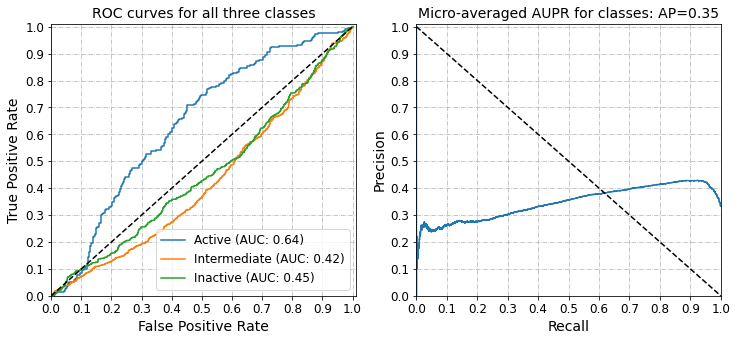

In [166]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=False)

In [117]:
collections.Counter(a)

Counter({2: 931, 1: 1994, 0: 1})